# Homework Assignment 4

## Topics: Variable engineering

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 1. Using pandas to read the data files

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


[Text(558.0, 761.04, 'trustLevel <= 1.5\ngini = 0.105\nsamples = 1315\nvalue = [1242, 73]'),
 Text(279.0, 543.6, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.4\nsamples = 228\nvalue = [165, 63]'),
 Text(139.5, 326.15999999999997, 'lineItemVoids <= 10.5\ngini = 0.027\nsamples = 74\nvalue = [73, 1]'),
 Text(69.75, 108.72000000000003, 'gini = 0.0\nsamples = 71\nvalue = [71, 0]'),
 Text(209.25, 108.72000000000003, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(418.5, 326.15999999999997, 'totalScanTimeInSeconds <= 895.0\ngini = 0.481\nsamples = 154\nvalue = [92, 62]'),
 Text(348.75, 108.72000000000003, 'gini = 0.325\nsamples = 93\nvalue = [74, 19]'),
 Text(488.25, 108.72000000000003, 'gini = 0.416\nsamples = 61\nvalue = [18, 43]'),
 Text(837.0, 543.6, 'grandTotal <= 99.145\ngini = 0.018\nsamples = 1087\nvalue = [1077, 10]'),
 Text(697.5, 326.15999999999997, 'trustLevel <= 2.5\ngini = 0.015\nsamples = 1076\nvalue = [1068, 8]'),
 Text(627.75, 108.72000000000003, 'gini = 0.063\nsamples =

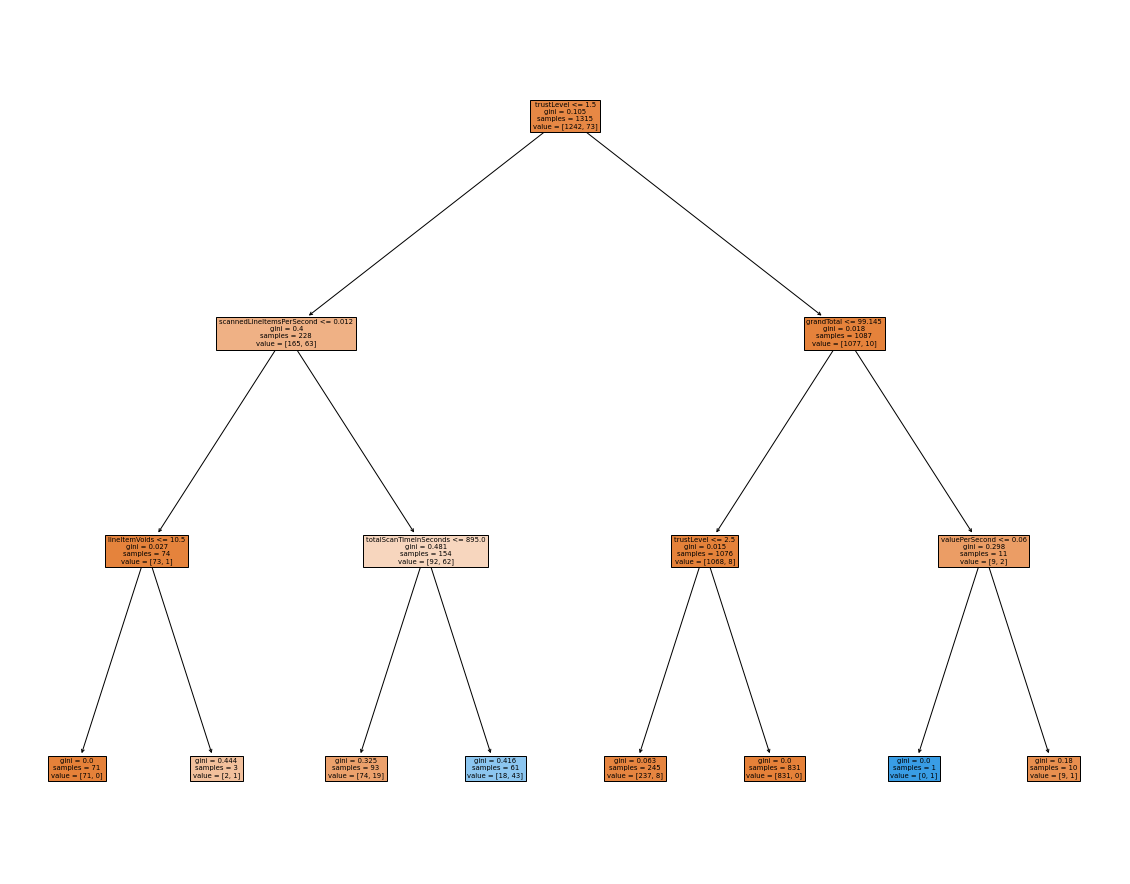

In [13]:
## 2. Using the train data-frame to engineer at least 7 different features that can help to predict fraud
## using the given input variables

## Creating decision tree to find new feature relationships

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [14]:
train.groupby('fraud').median()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
fraud,,,,,,,,,
0,3.0,916.0,51.26,5.0,5.0,3.0,0.015873,0.055407,0.363636
1,1.0,1309.5,48.67,6.0,7.0,2.0,0.020436,0.043697,0.245000


In [15]:
train.groupby('fraud').mean()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
fraud,,,,,,,,,
0,3.534085,917.988169,50.854541,5.416901,4.847887,2.525634,0.059693,0.210424,0.774348
1,1.144231,1173.913462,51.034327,6.375000,5.865385,2.519231,0.031582,0.053622,0.251412


In [16]:
## New variables:

## Variable 1
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (train['lineItemVoids'] <= 10.5), 0, 1)

## Variable 2
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & 
                                  (train['totalScanTimeInSeconds'] <= 895.0), 0, 1)

## Variable 3
train['Interaction_3'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] <= 99.145) & 
                                  train['trustLevel'] <= 2.5, 1, 0)

## Variable 4
train['Interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] > 99.145) & 
                                  train['valuePerSecond'] <= 0.06, 1, 0)

## Variable 5 - Low trustLevel
train['lowTrust'] = np.where(train['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
train['madeModification'] = np.where(train['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
train['madeScansWithoutRegistration'] = np.where(train['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds
train['lowTotalScanTime'] = np.where(train['totalScanTimeInSeconds'] < 1000, 1, 0)

In [17]:
## Engineering the same features on the test data-frame

## Variable 1
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (test['lineItemVoids'] <= 10.5), 0, 1)

## Variable 2
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & 
                                  (test['totalScanTimeInSeconds'] <= 895.0), 0, 1)

## Variable 3
test['Interaction_3'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] <= 99.145) & 
                                  test['trustLevel'] <= 2.5, 1, 0)

## Variable 4
test['Interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] > 99.145) & 
                                  test['valuePerSecond'] <= 0.06, 1, 0)

## Variable 5 - Low trustLevel
test['lowTrust'] = np.where(test['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
test['madeModification'] = np.where(test['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
test['madeScansWithoutRegistration'] = np.where(test['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds
test['lowTotalScanTime'] = np.where(test['totalScanTimeInSeconds'] < 1000, 1, 0)


In [26]:
## Testing the performance of a Random Forest Classifier with and without the new variables

## Defining the input and target variables
X = train.drop(columns = ['fraud', 'trustLevel'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [27]:
## With the variables

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       355
           1       0.74      0.67      0.70        21

    accuracy                           0.97       376
   macro avg       0.86      0.83      0.84       376
weighted avg       0.97      0.97      0.97       376



In [28]:
## Without the new variables

X_train = X_train.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3', 'Interaction_4', 'lowTrust', 
                                  'madeModification', 'madeScansWithoutRegistration', 'lowTotalScanTime'])
X_test = X_test.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3', 'Interaction_4', 'lowTrust', 
                                  'madeModification', 'madeScansWithoutRegistration', 'lowTotalScanTime'])

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       355
           1       0.13      0.86      0.23        21

    accuracy                           0.68       376
   macro avg       0.56      0.76      0.51       376
weighted avg       0.94      0.68      0.76       376

